# YOLO物体检测

In [2]:
import torch
import torch.nn as nn

# 缩微YOLO网络模型
class TinyYoloNetwork(nn.Module):
    def __init__(self):
        super(TinyYoloNetwork, self).__init__()
        # 从训练数据集中聚类得到的先验物体框尺寸，这是物体框最有可能的各种尺寸
        anchors = ((1.08,1.19), (3.42,4.41), (6.63,11.38), (9.42,5.11), (16.62,10.52))
        self.register_buffer("anchors", torch.tensor(anchors))
        # 物体类别数
        self.num_classes = 20
        # LeakyReLU作为激活函数，输入小于0时斜率为0.1
        self.relu = torch.nn.LeakyReLU(0.1, inplace=True)
        # 最大值池化层
        self.pool = torch.nn.MaxPool2d(2, stride=2)
        self.lastpool = torch.nn.MaxPool2d(2, 1)
        # 最后一个池化层之前的数据补齐
        self.pad = torch.nn.ReflectionPad2d((0, 1, 0, 1))
        # 批归一化层和卷积层
        self.norm1 = torch.nn.BatchNorm2d(16)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, stride=1, padding=1, bias=False)
        self.norm2 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, stride=1, padding=1, bias=False)
        self.norm3 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, stride=1, padding=1, bias=False)
        self.norm4 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(64, 128, 3, stride=1, padding=1, bias=False)
        self.norm5 = torch.nn.BatchNorm2d(256)
        self.conv5 = torch.nn.Conv2d(128, 256, 3, stride=1, padding=1, bias=False)
        self.norm6 = torch.nn.BatchNorm2d(512)
        self.conv6 = torch.nn.Conv2d(256, 512, 3, stride=1, padding=1, bias=False)
        self.norm7 = torch.nn.BatchNorm2d(1024)
        self.conv7 = torch.nn.Conv2d(512, 1024, 3, stride=1, padding=1, bias=False)
        self.norm8 = torch.nn.BatchNorm2d(1024)
        self.conv8 = torch.nn.Conv2d(1024, 1024, 3, stride=1, padding=1, bias=False)
        # 最后一个卷积层
        self.conv9 = torch.nn.Conv2d(1024, len(anchors) * (5 + self.num_classes), 1,
            stride=1, padding=0)

    def forward(self, x, yolo=True):
        # 将各模块组织为神经网络
        x = self.relu(self.pool(self.norm1(self.conv1(x))))
        x = self.relu(self.pool(self.norm2(self.conv2(x))))
        x = self.relu(self.pool(self.norm3(self.conv3(x))))
        x = self.relu(self.pool(self.norm4(self.conv4(x))))
        x = self.relu(self.pool(self.norm5(self.conv5(x))))
        x = self.relu(self.lastpool(self.pad(self.norm6(self.conv6(x)))))
        x = self.relu(self.norm7(self.conv7(x)))
        x = self.relu(self.norm8(self.conv8(x)))
        x = self.conv9(x)
        # 从神经网络的输出计算物体框位置和物体类别
        return self.yolo(x)
    
    def yolo(self, x):
        # 神经网络输出的结果形状如下：
        # 各维度依次是批次样本索引，输出通道，输出高度，输出宽度
        n_batch, n_channel, height, width = x.shape
        # 将输出通道拆分为若干先验物体框
        x = x.view(n_batch, self.anchors.shape[0], -1, height, width)
        # 重新调整各个维度的顺序如下
        # 批次样本索引，先验物体框，网格纵向序号，网格横向序号，位置及分类输出
        # 其中，位置及分类输出的维度尺寸是(5 + 类别数)
        x = x.permute(0, 1, 3, 4, 2)
        # 准备用于计算物体框位置的辅助张量
        # 首先是先验物体框的尺寸
        anchors = self.anchors.to(dtype=x.dtype, device=x.device)
        anchor_width, anchor_height = anchors[:, 0], anchors[:, 1]
        # 然后是网格的偏移量
        grid_y, grid_x = torch.meshgrid(
            torch.arange(height, dtype=x.dtype, device=x.device),
            torch.arange(width, dtype=x.dtype, device=x.device),
        )
        # 计算物体框位置和物体分类输出，最后一维各列分别是：
        # 中心位置横坐标，纵坐标，物体框宽度，高度，物体框包含物体的置信度，类别的Softmax输出
        return torch.cat([
            (x[:, :, :, :, 0:1].sigmoid() + grid_x[None,None,:,:,None]) / width,
            (x[:, :, :, :, 1:2].sigmoid() + grid_y[None,None,:,:,None]) / height,
            (x[:, :, :, :, 2:3].exp() * anchor_width[None,:,None,None,None]) / width,
            (x[:, :, :, :, 3:4].exp() * anchor_height[None,:,None,None,None]) / height,
            x[:, :, :, :, 4:5].sigmoid(),
            x[:, :, :, :, 5:].softmax(-1),
        ], -1)

x = torch.rand((1, 3, 320, 320))
net = TinyYoloNetwork()
y = net(x)
print(y.shape)
# 输出：torch.Size([1, 5, 10, 10, 25])

torch.Size([1, 5, 10, 10, 25])


In [3]:
!wget https://pjreddie.com/media/files/yolov2-tiny-voc.weights -O data/yolov2-tiny-voc.weights

--2021-08-22 07:01:38--  https://pjreddie.com/media/files/yolov2-tiny-voc.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63471556 (61M) [application/octet-stream]
Saving to: ‘data/yolov2-tiny-voc.weights’

data/yolov2-tiny-vo 100%[===================>]  60.53M  16.4MB/s    in 3.7s    

2021-08-22 07:01:43 (16.4 MB/s) - ‘data/yolov2-tiny-voc.weights’ saved [63471556/63471556]



In [4]:
import numpy

# 读取权值的辅助函数
# 从weights中offset位置读取权值到target
def load_weight_to(weights, offset, target):
    n = target.numel()
    target.data[:] = torch.from_numpy(weights[offset : offset + n]).view_as(target.data)
    return offset + n

# 从文件加载训练好的网络权值
def load_weights(network, filename="data/yolov2-tiny-voc.weights"):
    with open(filename, "rb") as file:
        # 读取版本号和训练状态记录
        header = numpy.fromfile(file, count=4, dtype=numpy.int32)
        # 其余所有值都是网络权值
        weights = numpy.fromfile(file, dtype=numpy.float32)
        idx = 0
        for layer in network.children():
            # 读取卷积层权值
            if isinstance(layer, torch.nn.Conv2d):
                if layer.bias is not None:
                    idx = load_weight_to(weights, idx, layer.bias)
                idx = load_weight_to(weights, idx, layer.weight)
            # 读取批归一化层权值
            if isinstance(layer, torch.nn.BatchNorm2d):
                idx = load_weight_to(weights, idx, layer.bias)
                idx = load_weight_to(weights, idx, layer.weight)
                idx = load_weight_to(weights, idx, layer.running_mean)
                idx = load_weight_to(weights, idx, layer.running_var)

load_weights(net)

In [5]:
import torchvision
from PIL import Image

def load_image(filename, width, height):
    img = Image.open(filename)
    scale = min(width / img.width, height / img.height)
    new_width, new_height = int(img.width * scale), int(img.height * scale)
    diff_width, diff_height = width - new_width, height - new_height
    padding = (diff_width // 2, diff_height // 2,
        diff_width // 2 + diff_width % 2,
        diff_height // 2 + diff_height % 2)
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(size=(new_height, new_width)),
        torchvision.transforms.Pad(padding=padding),
        torchvision.transforms.ToTensor()])
    return transforms(img).unsqueeze(0)

class_labels = (
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor",
)

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_images_with_boxes(input_tensor, output_tensor, class_labels, threshold):
    # 区分不同物体框的颜色表
    colors = ['r','g','b','y','c','m','k']
    to_img = torchvision.transforms.ToPILImage()
    img = to_img(input_tensor[0])
    # 显示图片
    plt.imshow(img)
    plt.axis('off')
    axis = plt.gca()
    # 将网络输出提取为numpy数组
    output = output_tensor[0].cpu().detach().numpy().reshape((-1, 5 + len(class_labels)))
    classes = numpy.argmax(output[:,5:], axis=-1)
    confidences = output[:,4] * numpy.max(output[:,5:], axis=-1)
    # 将物体框调整到输入图片的尺寸
    boxes = output[:,0:4]
    boxes[:,0::2] *= img.width
    boxes[:,1::2] *= img.height
    boxes[:,0:2] -= boxes[:,2:4] / 2
    # 逐个显示物体框
    for box, confidence, class_id in zip(boxes, confidences, classes):
        # 忽略掉置信度较低的物体框
        if confidence < threshold: continue
        # 绘制物体框
        color = colors[class_id % len(colors)]
        rect = patches.Rectangle(box[0:2], box[2], box[3],
            linewidth=1, edgecolor=color, facecolor='none')
        axis.add_patch(rect)
        label = class_labels[class_id]
        label = '{0}{1:.2f}'.format(label, confidence)
        plt.text(box[0], box[1], label, color='w', backgroundcolor=color)


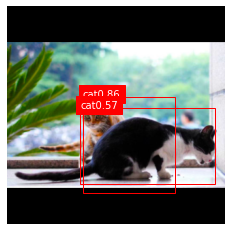

In [10]:
# net = TinyYoloNetwork()
# load_weights(net)
imgs = load_image('data/test.jpg', 320, 320)
output_tensor = net(imgs)
show_images_with_boxes(imgs, output_tensor, class_labels, 0.45)